Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

<class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'>
<class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'>
<class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'>
<class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'>
<class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'> <class 'numpy.str_'>


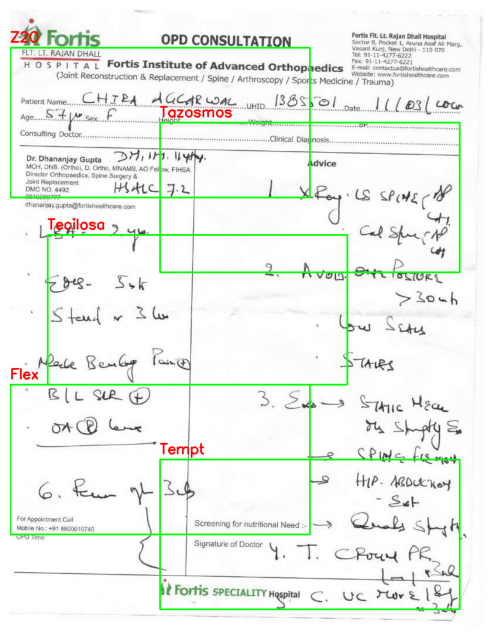

In [24]:
import torch
import numpy as np
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = VisionEncoderDecoderModel.from_pretrained('./trained_trocr_model').to(device)
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')

# Prediction function
def predict(image):
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    output_ids = trained_model.generate(pixel_values, max_new_tokens=16)
    prediction = processor.batch_decode(output_ids, skip_special_tokens=True)[0]
    return prediction

# Sliding window function
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def count_word(word_list, word_to_count):
    count = 0
    for word in word_list:
        if word == word_to_count:
            count += 1
    return count

# Non-Maximum Suppression (NMS) function
def non_maximum_suppression(boxes, overlap_thresh=0.3):
    if len(boxes) == 0:
        return []
    
    boxes = np.array(boxes)
    # print(boxes)
    x1 = np.array(boxes[:, 0],dtype=np.int32)
    y1 = np.array(boxes[:, 1],dtype=np.int32)
    x2 = np.array(boxes[:, 0],dtype=np.int32) + np.array(boxes[:,2],dtype=np.int32)
    y2 = np.array(boxes[:, 1],dtype=np.int32) + np.array(boxes[:,3],dtype=np.int32)
    scores = np.array([1.0 for i in range(len(boxes))])  # Simple score using text
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]
    detected_words=[txt for _,_,_,_,txt in boxes]
    
    words_freq_dict = []
    keep=[]
    for word in detected_words:
        count=count_word(detected_words,word)
        # i = order[0]
        words_freq_dict.append(count)
    
    # order = np.array(words_freq_dict).argsort()[::-1]
    # print(words_freq_dict,order)
    # print(words_freq_dict)
    while (order.shape[0] > 0):
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[order[1:]]
        order = order[np.where(overlap <= overlap_thresh)[0] + 1]
    return boxes[keep]

# Detection function
def detect_with_sliding_window(image_path, step_size=32, window_size=(128, 32)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detected_windows = []

    for (x, y, window) in sliding_window(image, step_size, window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue
        window_pil = Image.fromarray(window).convert('RGB')
        text = predict(window_pil)
        detected_windows.append((int(x), int(y), int(window_size[0]), int(window_size[1]), text))

    # Apply NMS to filter overlapping boxes
    filtered_windows = non_maximum_suppression(detected_windows)
    for box in filtered_windows:
        print(type(box[0]),type(box[1]),type(box[2]),type(box[3]),type(box[4]))
    # Display the detections
    display_detections(image, filtered_windows)

# Display function
def display_detections(image, detected_windows):
    for (x, y, w, h, prediction) in detected_windows:
        cv2.rectangle(image, (int(x), int(y)), (int(x) + int(w), int(y) + int(h)), (0, 255, 0), 2)
        text_position = (int(x), max(int(y) - 10, 20))
        cv2.putText(image, prediction, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Run detection
# path_img = 'path_to_your_image.jpg'  # Replace with your image path
detect_with_sliding_window(r'/home/sagnik/Projects/IEEE_Indicon_Intel/Handwritten-Medical Prescription/data/53.jpg', step_size=64, window_size=(512, 256))
